In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
# !pip install tensorflow-gpu==2.3.0
# !pip install sklearn

In [3]:
import tensorflow
import tensorflow as tf

In [4]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [6]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6549255191109754827,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11903037018009240111
 physical_device_desc: "device: XLA_CPU device"]

In [7]:
# part = 'right_arm'
# part = 'left_arm'
# part = 'right_leg' 
part = 'left_leg'

actions = ['assult', 'normal']

file_dir = 'C:/Users/BVer/are_you_ok/dataset/' + part + '/'#part 폴더를 dataset 폴더에 넣어주세요

npy_file = []
for name in os.listdir(file_dir):
    if not len(np.load(file_dir + name)) == 0:
        npy_file.append(np.load(file_dir + name))

data = np.concatenate(npy_file, axis=0)

data.shape

(2617, 30, 3)

In [8]:
if part == 'right_arm':
    for i in range(len(data)):
        for j in range(30):
            if data[i][j][2] in [1, 2, 4, 6]:
                data[i][j][2] = 0
            else: data[i][j][2] = 1
if part == 'left_arm':
    for i in range(len(data)):
        for j in range(30):
            if data[i][j][2] in [0, 2, 3, 5]:
                data[i][j][2] = 0
            else: data[i][j][2] = 1
if part == 'right_leg':
    for i in range(len(data)):
        for j in range(30):
            if data[i][j][2] in [8, 10, 12]:
                data[i][j][2] = 0
            else: data[i][j][2] = 1
if part == 'left_leg':
    for i in range(len(data)):
        for j in range(30):
            if data[i][j][2] in [7, 9, 11]:
                data[i][j][2] = 0
            else: data[i][j][2] = 1

In [9]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(2617, 30, 2)
(2617,)


In [10]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(2617, 2)

In [11]:
y_data[0]

array([0., 1.], dtype=float32)

In [12]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2355, 30, 2) (2355, 2)
(262, 30, 2) (262, 2)


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                17152     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 19,298
Trainable params: 19,298
Non-trainable params: 0
_________________________________________________________________


In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/' + part + '_model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
70/74 [===========================>..] - ETA: 0s - loss: 2.1026 - acc: 0.8817
Epoch 00001: val_acc improved from -inf to 0.89695, saving model to models\left_leg_model.h5
74/74 [==============================] - 2s 22ms/step - loss: 2.1316 - acc: 0.8790 - val_loss: 1.2581 - val_acc: 0.8969
Epoch 2/200
73/74 [============================>.] - ETA: 0s - loss: 8.7432 - acc: 0.8823
Epoch 00002: val_acc improved from 0.89695 to 0.96565, saving model to models\left_leg_model.h5
74/74 [==============================] - 1s 17ms/step - loss: 8.6849 - acc: 0.8824 - val_loss: 1.7723 - val_acc: 0.9656
Epoch 3/200
73/74 [============================>.] - ETA: 0s - loss: 3.0733 - acc: 0.9195
Epoch 00003: val_acc did not improve from 0.96565
74/74 [==============================] - 1s 17ms/step - loss: 3.0623 - acc: 0.9197 - val_loss: 0.3783 - val_acc: 0.9656
Epoch 4/200
71/74 [===========================>..] - ETA: 0s - loss: 0.5448 - acc: 0.9129
Epoch 00004: val_acc did not improve from

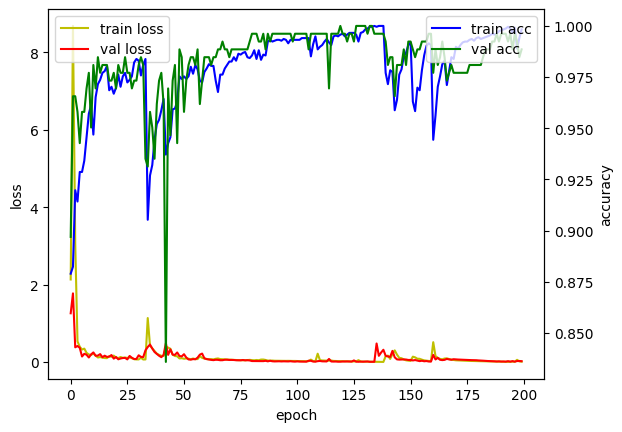

In [18]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()

In [19]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('./models/' + part + '_model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[[256,   0],
        [  0,   6]],

       [[  6,   0],
        [  0, 256]]], dtype=int64)

In [20]:
file_dir1 = 'C:/Users/BVer/are_you_ok/preprocessing'

In [21]:
raw_data = np.load(file_dir1 + '/kicking/' + 'raw_kicking_kicking_k24.mp4.npy')

In [28]:
raw_data = np.load(file_dir1 + '/raw_data/' + 'raw_0_slaping_k34.mp4_0_.npy')

In [29]:
raw_data.shape

(27, 67)

In [23]:
def pred_raw_part(test):
    test = test[:, 54:-1]
    seq_length = 30
    seq = []
    action_seq = []
    actions = ['assult', 'normal']
    right_arm_seq = [] #2,3
    left_arm_seq = [] #4,5
    right_leg_seq = [] #7,8
    left_leg_seq = [] #10,11

    right_arm_action = 0
    left_arm_action = 0
    right_leg_action = 0      
    left_leg_action = 0

    nan_skip_count = 10 #오차 허용 프레임
    
    right_arm_nan = 0
    left_arm_nan = 0
    right_leg_nan = 0      
    left_leg_nan = 0
        
    
#     print(x_test_data[0][0])
    for index, angle_data in enumerate(test):
        right_arm_nan = take_not_nan(angle_data[2], angle_data[3], right_arm_seq, right_arm_nan)
        left_arm_nan = take_not_nan(angle_data[4], angle_data[5], left_arm_seq, left_arm_nan)
        right_leg_nan = take_not_nan(angle_data[7], angle_data[8], right_leg_seq, right_leg_nan)
        left_leg_nan = take_not_nan(angle_data[10], angle_data[11], left_leg_seq, left_leg_nan)
        
        print(index, ' frame')
#         pred_part(right_arm_seq, right_arm_nan, right_arm_model, right_arm_action, 'right_arm')
#         pred_part(left_arm_seq, left_arm_nan, left_arm_model, left_arm_action, 'left_arm')
#         pred_part(right_leg_seq, right_leg_nan, right_leg_model, right_leg_action, 'right_leg')
        pred_part(left_leg_seq, left_leg_nan, model, left_leg_action, 'left_leg')
        
def pred_data(part_data, part_seq):
    seq_length = 30
    part_data = np.array(part_data)
    
    for seq in range(len(part_data) - seq_length):
        part_seq.append(part_data[seq:seq + seq_length])
    part_data = []

In [24]:
def take_not_nan(key1, key2, part_seq, part_nan):
    if not np.isnan(key1) and not np.isnan(key2):
        part_seq.append([key1, key2])
        return 0
    else:
        part_nan += 1
        if part_nan > 10: #오차 허용 프레임
            part_seq = []
            return 15
        else:
            return part_nan
        
def pred_part(part_seq, part_nan, part_model, part_action, part_name):
    seq_length = 30
    if len(part_seq) > seq_length and part_nan == 0:
        input_data = np.expand_dims(np.array(part_seq[-seq_length:], dtype=np.float32), axis=0)
        y_pred = part_model.predict(input_data).squeeze()

        print(part_name,' : ', y_pred)

        i_pred = int(np.argmax(y_pred))
        conf = y_pred[i_pred]

        if conf > 0.5 and actions[i_pred] == 'assult': #신뢰도
            part_action += 1
            if part_action > 3:
                print(part_name, '  detect  assult')
        else:
            part_action = 0
        return 100
    else:
        return 0
            

In [30]:
pred_raw_part(raw_data)

0  frame
1  frame
2  frame
3  frame
4  frame
5  frame
6  frame
7  frame
8  frame
9  frame
10  frame
11  frame
12  frame
13  frame
14  frame
15  frame
16  frame
17  frame
18  frame
19  frame
20  frame
21  frame
22  frame
23  frame
24  frame
25  frame
26  frame
